# Amazon Deforestation Forecasting Using AI/ML and IoT Data
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 11, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [ ]:
# install necessary libraries
!pip install geopandas

In [9]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Exploratory Data Analysis

Load geospatial shape files and evaluate.  Objectives are:

1.  Interrogate time series layer: yearly_deforsestation_biome
2.  Visualize the time series layer
3.  Check for mising values
4.  Evaluate value ranges of target variable
5.  Interrogate supporting layers and determine how to create normalized analytical dataset


In [10]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load geo data layers
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'
geo_yearly_deforestation_biome = gpd.read_file(root_dir + '/yearly_deforestation_biome/yearly_deforestation_biome.shp')

In [12]:
geo_states_amazon_biome = gpd.read_file(root_dir + '/states_amazon_biome/states_amazon_biome.shp')

In [13]:
geo_hydrography_biome = gpd.read_file(root_dir + '/hydrography_biome/hydrography_biome.shp')

In [14]:
geo_no_forest_biome = gpd.read_file(root_dir + '/no_forest_biome/no_forest_biome.shp')

### Interrogate the time series data layer

In [15]:
# display some samples
geo_yearly_deforestation_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
561151,217172,AM,23165,DESMATAMENTO,d2017,0.0,211,2017-07-30,2017.0,0.384669,100619.0,None,None,None,f18379cb-dbc4-4f4d-a124-21500f231bce,"POLYGON ((-60.83447 -7.60264, -60.83497 -7.601..."
234286,536527,PA,22361,DESMATAMENTO,d2015,2013.0,214,2015-08-02,2015.0,0.016990,2587.0,None,None,None,a8e93de9-0b43-4da7-86f3-3dac66825748,"POLYGON ((-47.59703 -0.81196, -47.59703 -0.811..."
47593,613823,AC,00466,DESMATAMENTO,d2020,NaN,214,2020-08-01,2020.0,0.065998,381.0,None,None,None,0cb52694-fc89-4184-b329-a147b522c573,"POLYGON ((-70.91401 -8.51221, -70.91379 -8.511..."
493282,146636,AM,23065,DESMATAMENTO,d2021,NaN,183,2021-07-02,2021.0,0.244710,1052.0,None,None,None,eb136a75-72df-41ac-ae49-a71f7f394c2b,"POLYGON ((-59.30363 -6.81465, -59.30327 -6.814..."
377630,28189,RR,23258,DESMATAMENTO,d2019,0.0,240,2019-08-28,2019.0,0.000455,101.0,None,None,None,6c903637-7bb8-45ce-ae82-0fb70dc841eb,"POLYGON ((-61.40560 2.57185, -61.40560 2.57221..."


In [16]:
# print descriptive statistics
geo_yearly_deforestation_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,666304.000000,510630.000000,666304.000000,666304.000000,666304.000000,665727.000000
mean,333152.500000,321.841846,219.746364,2015.468742,0.174381,20848.936883
std,192345.541219,737.740580,32.035579,4.530961,0.550267,39564.416673
min,1.000000,0.000000,1.000000,2008.000000,0.000000,1.000000
25%,166576.750000,0.000000,207.000000,2011.000000,0.065143,804.000000
50%,333152.500000,0.000000,219.000000,2016.000000,0.090982,1401.000000
75%,499728.250000,0.000000,233.000000,2019.000000,0.153751,2559.000000
max,666304.000000,2021.000000,363.000000,2022.000000,123.475783,101293.000000


In [17]:
#check data types
geo_yearly_deforestation_biome.dtypes

fid              int64
state           object
path_row        object
main_class      object
class_name      object
def_cloud      float64
julian_day       int64
image_date      object
year           float64
area_km        float64
scene_id       float64
source          object
satellite       object
sensor          object
uuid            object
geometry      geometry
dtype: object

In [18]:
# convert image_date to datetime
geo_yearly_deforestation_biome['image_date'] = pd.to_datetime(geo_yearly_deforestation_biome['image_date'])

In [19]:
# visualize the area_km total by year
yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()
yearly_deforestation['image_date'] = yearly_deforestation.index

<ipython-input-19-39dba510b50c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()


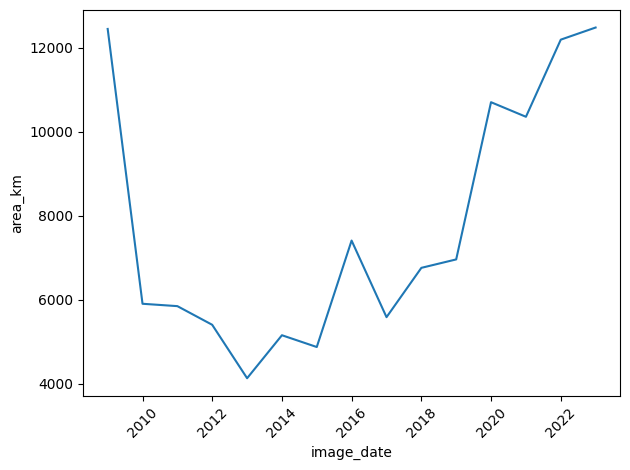

In [20]:
# line plot
sns.lineplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

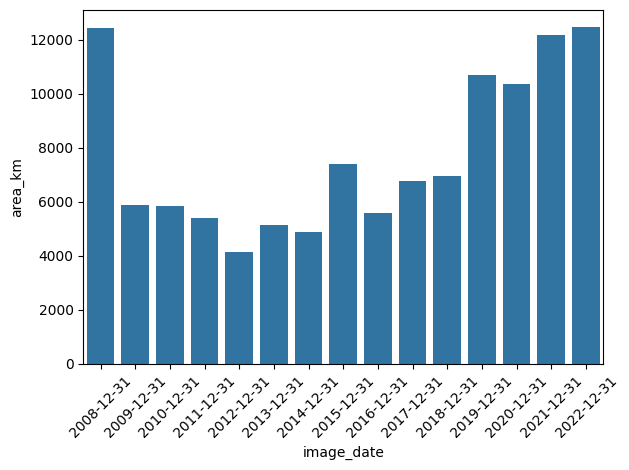

In [21]:
# show as bar graph
sns.barplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

In [22]:
# visualize the area_km total by state by year
state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()

<ipython-input-22-ad7e65832fbe>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()


In [23]:
state_deforestation

fid  def_cloud  julian_day       year     area_km  \
state image_date                                                            
AC    2008-12-31  826890113   303057.0      629500  5433648.0  288.792419   
      2009-12-31  518115260     8031.0      423648  3471552.0  161.738798   
      2010-12-31  813567682  1018516.0      577216  5374740.0  265.366641   
      2011-12-31  924697382    68333.0      688288  6149638.0  295.785591   
      2012-12-31  760215623   249362.0      546148  5176876.0  270.534694   
...                     ...        ...         ...        ...         ...   
TO    2018-12-31   16060203        0.0       10505   104936.0    4.760367   
      2019-12-31   19752636     2018.0       16298   147387.0    9.619698   
      2020-12-31   23576626        0.0       16767   149480.0   10.115500   
      2021-12-31   23891082        0.0       16586   147533.0   11.300232   
      2022-12-31   70207011        0.0       35250   299256.0   16.442140   

                   scene_id  
state image_date             
AC    2008-12-31  1758175.0  
      2009-12-31  1536732.0  
      2010-12-31  3008895.0  
      2011-12-31  3960568.0  
      2012-12-31  4032307.0  
...                     ...  
TO    2018-12-31  5256270.0  
      2019-12-31     4196.0  
      2020-12-31    48622.0  
      2021-12-31    81571.0  
      2022-12-31   232259.0  

[135 rows x 6 columns]

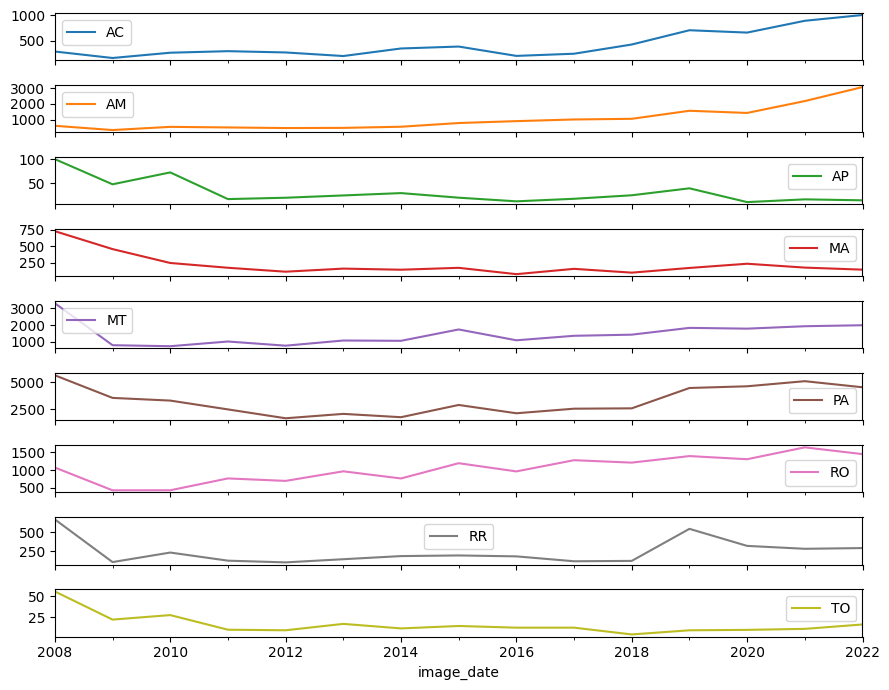

In [24]:
# plot by state
ax = state_deforestation.unstack(level=0).plot(kind='line', y='area_km', subplots=True, rot=0, figsize=(9, 7))
plt.tight_layout()

### Interrogate the supporting metadata layers

In [25]:
# check states metadata
geo_states_amazon_biome.sample(5)

,id,nome,sigla,geocodigo,geometry
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250..."
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112..."
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ..."
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ..."
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811..."


In [26]:
# check hydrography metadata
geo_hydrography_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
12389,12235,AM,23363,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.154439,0.0,None,None,None,02a95872-d93c-4e80-bdf0-051d9156e8b1,"POLYGON ((-64.26724 -4.85757, -64.26563 -4.857..."
6245,6065,PA,22961,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.135296,0.0,None,None,None,9d91846f-550a-4d37-b328-cf25a47b6571,"POLYGON ((-56.65711 -2.11266, -56.65603 -2.112..."
24810,24735,AM,00459,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.000024,0.0,None,None,None,f989148c-a976-4b99-a7c8-bad2f1d49171,"POLYGON ((-68.16565 1.73104, -68.16559 1.73104..."
22675,22604,RR,23158,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.067078,0.0,None,None,None,10ba8090-d061-4877-94a3-686eacd9dea1,"POLYGON ((-59.76836 3.63371, -59.76621 3.63371..."
29786,29738,AM,23062,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.151197,0.0,None,None,None,d96c5d4d-62f8-4fdc-a0ce-3b290610a9b9,"POLYGON ((-59.28725 -3.13947, -59.28553 -3.139..."


In [27]:
# check metadata of areas with no forest
geo_no_forest_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
46048,45903,AM,00259,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.000730,0.0,None,None,None,6f2a6bd6-74ae-4a36-9bdc-8e6949ba8552,"POLYGON ((-66.04812 0.73171, -66.04722 0.73171..."
37250,37048,TO,22366,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.764618,0.0,None,None,None,33db7aca-9b72-431c-8de6-24b21879b14a,"POLYGON ((-49.01262 -8.39358, -49.01223 -8.393..."
45799,45651,MT,23167,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.182513,0.0,None,None,None,6b3262d1-a78f-43f0-b33e-3b4e36598672,"POLYGON ((-61.36471 -10.01780, -61.36256 -10.0..."
32017,31777,MT,22968,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.005980,0.0,None,None,None,7674daf3-a195-4948-a908-f258f048ee03,"POLYGON ((-59.63827 -11.99876, -59.63827 -11.9..."
2198,1705,RR,23158,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.663896,0.0,None,None,None,0e8e5cc2-af9f-4f44-ac68-55aac2866b81,"POLYGON ((-60.13071 2.39739, -60.12882 2.39739..."


### Hydrography and No Forest layers appear to have some time element, investigate these further

In [28]:
# start with hydrography
geo_hydrography_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,32017.000000,31951.0,31951.0,31951.0,32017.000000,31951.0
mean,16009.000000,0.0,0.0,2007.0,3.411629,0.0
std,9242.656121,0.0,0.0,0.0,75.965504,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,8005.000000,0.0,0.0,2007.0,0.005568,0.0
50%,16009.000000,0.0,0.0,2007.0,0.067546,0.0
75%,24013.000000,0.0,0.0,2007.0,0.234795,0.0
max,32017.000000,0.0,0.0,2007.0,5616.250641,0.0


For hydrography, analysis shows that all of the data was collected in 2007, so just need to group and sum by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

In [29]:
# start with hydrography
geo_no_forest_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,52528.000000,51942.0,51942.0,51942.0,52528.000000,51942.0
mean,26264.500000,0.0,0.0,2007.0,5.324204,0.0
std,15163.671807,0.0,0.0,0.0,131.468175,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,13132.750000,0.0,0.0,2007.0,0.033840,0.0
50%,26264.500000,0.0,0.0,2007.0,0.092565,0.0
75%,39396.250000,0.0,0.0,2007.0,0.285425,0.0
max,52528.000000,0.0,0.0,2007.0,18363.179058,0.0


No forest data is also all collected in 2007, so will group by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

## Data Cleanup and Preparation

Clean up the dataset and prepare for modeling.  Objectives are:

1.  Remove empty values
2.  Remove columns we do not need
3.  Summarize supporting datasets to state and year
4.  Merge dataset features from supporting datasets to time-series
5.  Normalize values
6.  One-hot encode categorical values


### Start cleanup of supporting layers
Cleanup and consolidate hydrography and no forest layers

<Axes: >

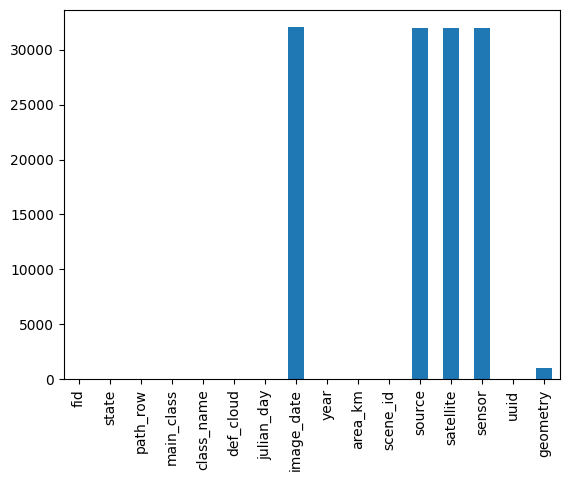

In [30]:
# visualize missing data
geo_hydrography_biome.isna().sum().plot.bar()

For hydrography layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

---



In [31]:
# drop unnecessary columns
geo_hydrography_clean = geo_hydrography_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)


In [32]:
geo_hydrography_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
9289,9129,AM,23162,2007.0,0.926467,a2bc2222-7cbf-4bcb-a74a-bb6c5823851c,"POLYGON ((-61.38246 -3.44640, -61.38192 -3.446..."
10693,10544,AM,23360,2007.0,0.156761,30c4d9fa-95e5-42db-9c36-ceb83227ac9a,"POLYGON ((-63.45352 -0.21921, -63.45298 -0.219..."
30589,30545,MT,23067,2007.0,0.023659,d32a694b-8324-4c5f-93fb-1ee6d174cf8f,"POLYGON ((-61.08172 -10.46730, -61.08118 -10.4..."
31048,31019,AM,23062,2007.0,0.117383,694f1299-f13e-4ee1-8f36-a189b4becf0e,"POLYGON ((-58.61232 -3.28742, -58.61206 -3.287..."
30574,30532,MT,23067,2007.0,0.050874,c57a13fd-a288-4d4f-962c-208d3e33647f,"POLYGON ((-60.85119 -10.14423, -60.85065 -10.1..."


In [33]:
# roll up total area to the state level
geo_hydrography_state = geo_hydrography_clean.groupby(['state'])['area_km'].sum()

In [34]:
geo_hydrography_state.sample(9)

state
AC      113.339475
TO      395.633885
AP     3461.356696
RO     1766.086970
MT     1728.346000
MA     4818.959857
AM    51077.536558
RR     1753.155361
PA    44115.717775
Name: area_km, dtype: float64

<Axes: >

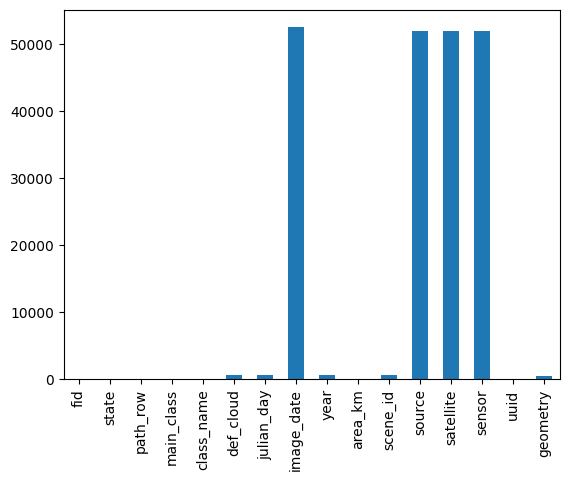

In [35]:
# visualize missing data
geo_no_forest_biome.isna().sum().plot.bar()

For no_forest layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

In [36]:
# drop unnecessary columns
geo_noforest_clean = geo_no_forest_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [37]:
geo_noforest_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
7767,7301,MT,22869,2007.0,0.000672,09bc0eb5-154d-4e90-8a27-64b5b46b2d1f,"POLYGON ((-58.02803 -13.00470, -58.02803 -13.0..."
14742,14325,PA,22959,2007.0,0.096154,362b45f8-effd-490f-a608-a6e5220bb848,"POLYGON ((-56.46101 1.71117, -56.45886 1.71117..."
15627,15208,RO,23367,2007.0,5.412788,8acfd937-c8c0-426d-bf97-58524c3f77e4,"POLYGON ((-65.18774 -9.41336, -65.18720 -9.413..."
43856,43684,AP,22658,2007.0,0.135189,38fd078f-0d41-4f6f-85ba-daa56c2f7d7e,"POLYGON ((-51.59023 3.13391, -51.58969 3.13391..."
51425,51262,MT,22468,2007.0,0.031887,20059c66-778f-45b9-8bdc-0416f9f53d82,"POLYGON ((-51.26537 -12.36147, -51.26537 -12.3..."


In [38]:
# roll up total area to the state level
geo_noforest_state = geo_noforest_clean.groupby(['state'])['area_km'].sum()

In [39]:
geo_noforest_state.sample(9)

state
RR    60902.109316
MA     8166.208790
PA    66845.300030
AM    48506.459703
TO      932.081272
MT    45068.972799
AC       70.051073
AP    25883.222690
RO    23295.406781
Name: area_km, dtype: float64

### Create calculated field for state dataset and merge in the hydrography and no_forest calcluated above for each state

In [40]:
# calculate area (km^2) for each state
geo_states_amazon_biome['area'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=5880).area / 1000
geo_states_amazon_biome

,id,nome,sigla,geocodigo,geometry,area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08


In [41]:
# rename state to use as key
geo_states_amazon_biome = geo_states_amazon_biome.rename(columns={"sigla": "state"})

In [42]:
# mege hydrography area for each state
geo_states_amazon_merge_1 = geo_states_amazon_biome.merge(geo_hydrography_state, how='left', left_on='state', right_index=True)

In [43]:
# rename state to use as key
geo_states_amazon_merge_1 = geo_states_amazon_merge_1.rename(columns={"area_km": "hydro_area"})

In [44]:
geo_states_amazon_merge_1

,id,nome,state,geocodigo,geometry,area,hydro_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857


In [45]:
# mege no forest area for each state
geo_states_amazon_merged = geo_states_amazon_merge_1.merge(geo_noforest_state, how='left', left_on='state', right_index=True)

In [46]:
# rename state to use as key
geo_states_amazon_merged = geo_states_amazon_merged.rename(columns={"area_km": "no_forest_area"})

In [47]:
geo_states_amazon_merged

,id,nome,state,geocodigo,geometry,area,hydro_area,no_forest_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475,70.051073
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361,60902.109316
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696,25883.222690
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885,932.081272
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000,45068.972799
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857,8166.208790


### Prepare time-series dataset

1. Inspect and clean as necessary
2. Drop unnecessary columns
3. Merge state data to time series
4. Normalize all numeric values
5. One-hot enc

<Axes: >

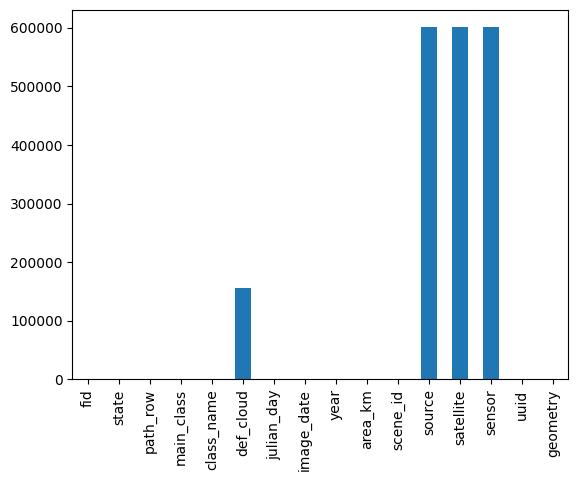

In [48]:
# visualize missing data
geo_yearly_deforestation_biome.isna().sum().plot.bar()

#### Clean and Merge
Drop columns that will not be useful in our model training (ie: state name) and those that are full of empty values.  Merge the columns from our state dataset with our time series dataset.

In [49]:
# drop columns we don't need
yearly_deforestation_clean = geo_yearly_deforestation_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [50]:
# merge state data in
yearly_deforestation_merged = yearly_deforestation_clean.merge(geo_states_amazon_merged, how='left', left_on='state', right_on='state')

In [51]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,id,nome,geocodigo,geometry_y,area,hydro_area,no_forest_area
536133,192045,PA,22762,2021-07-25,2021.0,0.072244,c31ce61e-fd59-45e4-b3f8-5d894b0b8ce2,"POLYGON ((-54.83006 -2.45633, -54.82804 -2.456...",6,Pará,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
327834,507883,AM,23165,2022-08-29,2022.0,0.038929,6c578d1b-9412-4a72-b63e-e327dabfb3e9,"POLYGON ((-61.37570 -7.53803, -61.37570 -7.538...",4,Amazonas,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
64812,616465,PA,22462,2009-09-09,2009.0,0.101335,1a24091e-6d75-46bc-82fc-e8977f462b4c,"POLYGON ((-49.38578 -2.90867, -49.38578 -2.907...",6,Pará,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
651013,310524,AC,00466,2014-08-17,2014.0,0.091646,92eb7af4-c0ae-42f7-b1be-afad7cb1e08b,"POLYGON ((-70.87359 -8.47966, -70.87224 -8.479...",3,Acre,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475,70.051073
262557,607005,RO,23267,2017-07-21,2017.0,0.284753,33b37850-7730-44cb-b2ec-9932d9629314,"POLYGON ((-63.80113 -9.68756, -63.80113 -9.687...",2,Rondônia,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781


In [52]:
# clean up merged columns we don't need
yearly_deforestation_merged = yearly_deforestation_merged.drop(['nome', 'id', 'geocodigo', 'geometry_y'], axis=1)

In [53]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,area,hydro_area,no_forest_area
358294,27929,PA,22765,2016-02-22,2016.0,0.065404,5e1366da-4809-4b0b-84b5-444d1aebd281,"POLYGON ((-55.57522 -7.51739, -55.57504 -7.516...",1.238830e+09,44115.717775,66845.300030
303081,483394,AC,00267,2022-08-17,2022.0,0.112760,c4948e16-832a-42c9-9b3c-617d1c777f52,"POLYGON ((-68.86153 -10.62849, -68.86152 -10.6...",1.707994e+08,113.339475,70.051073
625684,284721,MT,22870,2018-07-12,2018.0,0.090415,8abf72b9-080e-4254-8563-bf8d10bd8c9a,"POLYGON ((-57.81598 -14.88105, -57.81474 -14.8...",5.130396e+08,1728.346000,45068.972799
35424,370507,PA,22362,2015-08-02,2015.0,0.047488,ec2aec57-3680-4c4d-b1de-4e806c4f6409,"POLYGON ((-48.18248 -2.51742, -48.18248 -2.518...",1.238830e+09,44115.717775,66845.300030
655595,315357,MA,22164,2010-07-05,2010.0,0.096010,a1ab5c6a-12eb-4a4c-895e-d4e6ce4f6bd3,"POLYGON ((-45.82296 -5.19195, -45.82278 -5.191...",1.137373e+08,4818.959857,8166.208790


In [54]:
# cleanup column names
yearly_deforestation_merged = yearly_deforestation_merged.rename(columns={"area": "state_area", "geometry_x": "geometry", "hydro_area": "state_hydro_area", "no_forest_area": "state_no_forest_area", "area_km": "deforest_area_km"})

In [55]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area
444798,97470,AM,00266,2018-08-14,2018.0,0.067966,da2b7450-087a-42bb-8956-4ad667b508aa,"POLYGON ((-67.62946 -8.79491, -67.62749 -8.795...",1.589484e+09,51077.536558,48506.459703
317681,497847,PA,22362,2022-07-24,2022.0,0.078589,fc4c952b-ba12-43f3-acdc-5d97bbf692b3,"POLYGON ((-47.62923 -3.71263, -47.62923 -3.712...",1.238830e+09,44115.717775,66845.300030
192536,451567,RR,23258,2012-06-22,2012.0,0.104236,a3a4fbcd-c396-4224-bd05-833b22c9e0d4,"POLYGON ((-60.64836 2.54019, -60.64719 2.54019...",2.253429e+08,1753.155361,60902.109316
649709,309199,RO,00167,2008-07-26,2008.0,0.582483,303ebc2c-5b7d-4007-875c-4a4a41f494d7,"POLYGON ((-66.45086 -9.64011, -66.44898 -9.640...",2.377802e+08,1766.086970,23295.406781
288371,394624,RR,23258,2016-08-19,2016.0,0.013612,e49ee3fa-ab5f-438c-a2fa-96e609fd0451,"POLYGON ((-60.54452 2.16458, -60.54452 2.16461...",2.253429e+08,1753.155361,60902.109316


In [56]:
# extract lat and long into discreet columns
yearly_deforestation_merged['lat'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.y
yearly_deforestation_merged['long'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.x
yearly_deforestation_merged.sample(5)

<ipython-input-56-52eb932b7d02>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  yearly_deforestation_merged['lat'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.y
<ipython-input-56-52eb932b7d02>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  yearly_deforestation_merged['long'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.x


,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
192495,451526,RR,23258,2008-08-13,2008.0,0.213029,f99a7bcc-137c-4c4d-a736-754a8def4961,"POLYGON ((-61.59470 2.25693, -61.59470 2.25721...",2.253429e+08,1753.155361,60902.109316,2.257850,-61.592612
281255,274279,MT,23066,2022-08-30,2022.0,0.060971,b38bb847-f46b-429c-9df1-1f238ab12e9d,"POLYGON ((-60.33215 -9.32641, -60.33279 -9.325...",5.130396e+08,1728.346000,45068.972799,-9.325201,-60.331511
436579,88752,MT,22967,2015-07-27,2015.0,0.068152,f4d9593f-cd0a-44a1-9319-61f09b64911c,"POLYGON ((-59.03538 -9.57165, -59.03538 -9.571...",5.130396e+08,1728.346000,45068.972799,-9.572669,-59.034203
581388,238714,MT,22967,2011-08-01,2011.0,0.111919,def026e5-be77-422c-97ab-6b4df3b36255,"POLYGON ((-58.53176 -10.78902, -58.53176 -10.7...",5.130396e+08,1728.346000,45068.972799,-10.788563,-58.530441
209342,557208,PA,22464,2014-07-05,2014.0,0.003546,f50dde27-aa4b-4122-b221-ba3b666f403b,"POLYGON ((-50.07801 -5.71810, -50.07774 -5.718...",1.238830e+09,44115.717775,66845.300030,-5.718642,-50.077872


In [57]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
362949,13013,PA,22463,2010-07-26,2010.0,0.074691,2c453dea-8e1b-4d1d-99a5-527f65626312,"POLYGON ((-49.93920 -3.81923, -49.93920 -3.819...",1.238830e+09,44115.717775,66845.300030,-3.817765,-49.937677
233483,535717,RO,23266,2011-08-06,2011.0,0.024260,d0ab7531-e142-42ef-a890-33845f5a323c,"POLYGON ((-63.48150 -8.54987, -63.48147 -8.549...",2.377802e+08,1766.086970,23295.406781,-8.549463,-63.480132
4720,331457,PA,22761,2009-08-29,2009.0,0.120683,eae4f3b9-e4a7-4353-aa3b-59ecfcdc35c6,"POLYGON ((-54.87777 -1.76407, -54.87777 -1.763...",1.238830e+09,44115.717775,66845.300030,-1.762504,-54.876566
289019,404338,PA,22661,2009-07-21,2009.0,0.085147,563f203a-59ae-4376-b3e1-66e20bde028f,"POLYGON ((-52.72583 -0.92372, -52.72314 -0.923...",1.238830e+09,44115.717775,66845.300030,-0.924895,-52.724324
168070,632063,PA,22564,2020-09-14,2020.0,0.202983,b9a50199-8f76-4d47-a26f-d0df9fc71f2a,"POLYGON ((-51.81525 -5.71529, -51.81525 -5.714...",1.238830e+09,44115.717775,66845.300030,-5.716414,-51.812158


In [58]:
# save checkpoint of dataset (so we don't have to re-run all preprocessing above)
#yearly_deforestation_merged.to_csv('/content/drive/MyDrive/USD/datasets/amazon_deforestation/yearly_deforestation_merged.csv')

In [59]:
# load checkpoint of dataset
#yearly_deforestation_merged_copy = pd.read_csv('/content/drive/MyDrive/USD/datasets/amazon_deforestation/yearly_deforestation_merged.csv')

In [60]:
yearly_deforestation_merged_copy.sample(5)

,Unnamed: 0,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
179222,179222,644009,PA,22366,2015-09-19,2016.0,0.046563,0cef2adf-a14a-40a6-a75c-ebdb0e2648a0,POLYGON ((-50.19507403320165 -9.00589883246018...,1.238830e+09,44115.717775,66845.300030,-9.005118,-50.194235
549599,549599,205600,AM,166,2009-07-29,2009.0,0.261615,884d923c-10b7-4b98-b8df-036c63bfe1d8,POLYGON ((-66.53004696138507 -9.33506980541541...,1.589484e+09,51077.536558,48506.459703,-9.333933,-66.525361
270382,270382,71487,AM,23265,2021-08-17,2021.0,0.524427,f54407d9-7302-4436-8c27-b511f0b68b58,POLYGON ((-63.472203385465875 -7.8923758540943...,1.589484e+09,51077.536558,48506.459703,-7.889275,-63.469802
437863,437863,90068,RO,23267,2015-08-01,2015.0,0.073337,6cb78391-076d-405d-b41f-d93336394a33,POLYGON ((-63.678646961558904 -10.349080824330...,2.377802e+08,1766.086970,23295.406781,-10.349001,-63.677215
285404,285404,622214,PA,22565,2019-08-11,2019.0,0.067333,7f5af16a-ce5b-4f13-834c-166f7ee27f7b,POLYGON ((-51.434035962504105 -6.9407086383089...,1.238830e+09,44115.717775,66845.300030,-6.939833,-51.435961


#### Normalize numeric values with min-max scaling
Use min-max scaler from scikit-learn to scale the numeric values (area values) to 0-1 values making it easier for our models to work with

In [61]:
yearly_deforestation_merged_copy = yearly_deforestation_merged.copy()

In [62]:
# initialize scaler
scaler = MinMaxScaler()

In [63]:
# Normalize numeric area columns with min/max scaling
yearly_deforestation_merged[['deforest_area_km','state_area', 'state_hydro_area', 'state_no_forest_area']] = scaler.fit_transform(yearly_deforestation_merged[['deforest_area_km','state_area', 'state_hydro_area', 'state_no_forest_area']])

In [64]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
120598,408300,AM,23065,2018-07-26,2018.0,5.587220e-04,026e81f4-2977-4efb-a829-691e7eb0fcc8,"POLYGON ((-59.92488 -6.95384, -59.92466 -6.953...",1.000000,1.000000,0.725365,-6.953360,-59.922955
558242,214215,PA,22864,2009-08-20,2009.0,8.167803e-04,4a0ab7fe-1d9f-47a8-ac45-736321c68b76,"POLYGON ((-55.96308 -5.25112, -55.96120 -5.251...",0.775897,0.863398,1.000000,-5.252942,-55.960793
6516,333232,AM,00166,2015-07-30,2015.0,6.045985e-05,b7e25141-55d6-4780-801b-76008dbe69ca,"POLYGON ((-66.83807 -8.61443, -66.83804 -8.614...",1.000000,1.000000,0.725365,-8.614361,-66.837313
542394,198447,PA,22464,2008-08-21,2008.0,6.246583e-04,a40bbcb6-4eb8-4023-b531-3d70c80768b5,"POLYGON ((-50.52246 -5.52900, -50.52266 -5.529...",0.775897,0.863398,1.000000,-5.528124,-50.520841
505321,159894,PA,22562,2015-07-15,2015.0,3.510892e-07,e5ff224e-53d5-42d0-9992-631e697332d6,"POLYGON ((-51.29554 -3.50676, -51.29554 -3.506...",0.775897,0.863398,1.000000,-3.506717,-51.295521


#### One hot encode state column


In [68]:
# get one hot encodings
dummies = pd.get_dummies(yearly_deforestation_merged['state'], prefix='state')
dummies

,state_AC,state_AM,state_AP,state_MA,state_MT,state_PA,state_RO,state_RR,state_TO
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
666299,0,0,0,0,0,1,0,0,0
666300,1,0,0,0,0,0,0,0,0
666301,0,1,0,0,0,0,0,0,0
666302,0,0,0,0,0,0,1,0,0


In [69]:
#merge back into df
yearly_deforestation_merged = pd.concat([yearly_deforestation_merged, dummies], axis=1)

In [70]:
# inspect
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,...,long,state_AC,state_AM,state_AP,state_MA,state_MT,state_PA,state_RO,state_RR,state_TO
117108,404770,AM,23063,2020-07-31,2020.0,0.000565,05adf4d3-726d-46d6-a216-4a5861eaf28a,"POLYGON ((-59.73900 -3.88580, -59.73876 -3.885...",1.000000,1.000000,...,-59.738906,0,1,0,0,0,0,0,0,0
198538,457718,PA,22462,2008-08-21,2008.0,0.000569,5e2ac22a-d6ba-4443-b6fa-a35a101d96a0,"POLYGON ((-50.10141 -2.57592, -50.10141 -2.575...",0.775897,0.863398,...,-50.099661,0,0,0,0,0,1,0,0,0
291313,626902,PA,22261,2019-09-05,2019.0,0.000004,53a1ed75-8c86-48f8-84dd-84f21b2c9f52,"POLYGON ((-46.49320 -1.99953, -46.49303 -1.999...",0.775897,0.863398,...,-46.493085,0,0,0,0,0,1,0,0,0
331250,511279,PA,22763,2022-08-17,2022.0,0.000597,40cc5832-468c-48c5-b7da-c5a2939eb8d9,"POLYGON ((-55.27137 -4.19835, -55.27072 -4.198...",0.775897,0.863398,...,-55.274760,0,0,0,0,0,1,0,0,0
541943,197990,MT,23067,2009-09-03,2009.0,0.000667,bf525893-9833-4013-9479-c5e58f87bbe6,"POLYGON ((-59.78971 -9.87952, -59.78971 -9.879...",0.312044,0.031689,...,-59.787397,0,0,0,0,1,0,0,0,0


## Clustering by lat/long
We will create clusters of detected deforestations to segment the data by more granular location than state.  These clusters will be used downstream in modeling to forecast new deforestation in each cluster area and new activity in each cluster (activity defined by unique count of deforestation activity).

DBSCAN is used due to its suitability to lat/lon geodata as outlined here:
https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [71]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [87]:
# check for nulls in our lat/long
yearly_deforestation_merged.isna().sum()

fid                       0
state                     0
path_row                  0
image_date                0
year                      0
deforest_area_km          0
uuid                      0
geometry                435
state_area                0
state_hydro_area          0
state_no_forest_area      0
lat                     435
long                    435
state_AC                  0
state_AM                  0
state_AP                  0
state_MA                  0
state_MT                  0
state_PA                  0
state_RO                  0
state_RR                  0
state_TO                  0
dtype: int64

In [88]:
# drop samples with null lat/long
yearly_deforestation_merged = yearly_deforestation_merged.dropna()

In [98]:
# extract lat/long
coords = yearly_deforestation_merged[['lat', 'long']]

In [94]:
# setup cluster parameters and fit model
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))


In [120]:
# merge labels into main df
yearly_deforestation_merged['cluster'] = cluster_labels

In [122]:
# inspect
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,...,state_AC,state_AM,state_AP,state_MA,state_MT,state_PA,state_RO,state_RR,state_TO,cluster
163595,627542,AM,23065,2018-07-26,2018.0,0.001348,93e9edef-cf01-497f-8a2c-0c6ec6c18c17,"POLYGON ((-60.01307 -6.86890, -60.01301 -6.868...",1.000000,1.000000,...,0,1,0,0,0,0,0,0,0,681
47379,613615,AM,00565,2020-08-05,2020.0,0.001074,faf00333-607a-46e3-a16d-231f5890d6bc,"POLYGON ((-71.69215 -6.98695, -71.69214 -6.986...",1.000000,1.000000,...,0,1,0,0,0,0,0,0,0,-1
170514,635175,PA,22563,2016-07-17,2016.0,0.000189,d57afa80-969a-4efc-81fd-7d6c42ca8680,"POLYGON ((-51.04779 -4.18481, -51.04779 -4.184...",0.775897,0.863398,...,0,0,0,0,0,1,0,0,0,2512
553436,209421,PA,22762,2019-07-24,2019.0,0.000898,9dea2611-d4d3-4713-b5fe-fa786c14e1b5,"POLYGON ((-54.65759 -3.35978, -54.65742 -3.359...",0.775897,0.863398,...,0,0,0,0,0,1,0,0,0,228
7852,334550,AM,00463,2011-08-09,2011.0,0.000511,768923ae-a59b-476b-8f4b-746d98fc89f4,"POLYGON ((-70.44752 -4.16786, -70.44752 -4.167...",1.000000,1.000000,...,0,1,0,0,0,0,0,0,0,-1


<Figure size 3000x3000 with 0 Axes>

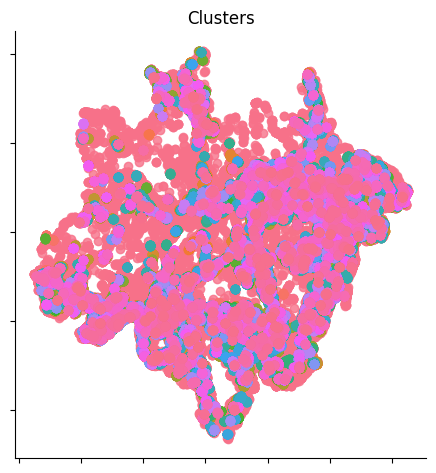

In [126]:
# visualize the clusters
plt.figure(figsize=(30, 30))
lmp = sns.lmplot( x="long", y="lat", data=yearly_deforestation_merged, fit_reg=False, hue='cluster', legend=False)
lmp.set(xticklabels=[])  # remove the tick labels
lmp.set(xlabel=None)
lmp.set(yticklabels=[])  # remove the tick labels
lmp.set(ylabel=None)
plt.title('Clusters')
plt.show()

In [130]:
yearly_deforestation_merged_geo = gpd.GeoDataFrame(yearly_deforestation_merged, geometry=yearly_deforestation_merged['geometry'])

In [132]:
# save checkpoint of dataset (so we don't have to re-run all preprocessing above)
yearly_deforestation_merged_geo.to_file('/content/drive/MyDrive/USD/datasets/amazon_deforestation/yearly_deforestation_merged.json', driver='GeoJSON')